# Econ 441B Week 2 Assignment
# Richard Grigorian (UID: 505-088-797)
## 1.) Import the data from CCLE

In [48]:
import pandas as pd
import numpy as np
# from google.colab import drive
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [ ]:
# drive.mount('/content/gdrive/', force_remount = True)

In [27]:
df = pd.read_csv('insurance.csv')

In [28]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [29]:
# Sex variable --> binary
df.loc[df["sex"] == "female", "sex"] = 1.
df.loc[df["sex"] == "male", "sex"] = 0.
# Smoker variable --> binary
df.loc[df["smoker"] == "yes", "smoker"] = 1.
df.loc[df["smoker"] == "no", "smoker"] = 0.
# Pull region variable dummies & join data frames
df_dummies = pd.get_dummies(df["region"])
df = df.join(df_dummies)

In [30]:
# Dropping original region variable
df1 = df.copy()
df1.drop(columns = ["region"])

# Changing column order
list(df1.columns.values)
df1 = df1[['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'northeast',
 'northwest',
 'southeast',
 'southwest',
 'charges']]

In [31]:
# Cleaned Data Set
df1

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest,charges
0,19,1.0,27.900,0,1.0,0,0,0,1,16884.92400
1,18,0.0,33.770,1,0.0,0,0,1,0,1725.55230
2,28,0.0,33.000,3,0.0,0,0,1,0,4449.46200
3,33,0.0,22.705,0,0.0,0,1,0,0,21984.47061
4,32,0.0,28.880,0,0.0,0,1,0,0,3866.85520
...,...,...,...,...,...,...,...,...,...,...
1333,50,0.0,30.970,3,0.0,0,1,0,0,10600.54830
1334,18,1.0,31.920,0,0.0,1,0,0,0,2205.98080
1335,18,1.0,36.850,0,0.0,0,0,1,0,1629.83350
1336,21,1.0,25.800,0,0.0,0,0,0,1,2007.94500


## 2.) Split the data into 80/20, in/out sample

In [37]:
# Independent and dependent variables as arrays
data = np.array(df1.iloc[:,:-1])
target = np.array(df1.iloc[:,-1])

In [39]:
# Defining naive 80% cut in data
cut = int((len(data)* .8) //1)

In [40]:
# Splitting data into 80/20 in/out sample
in_data = data[:cut]
out_data = data[cut:]

in_target = target[:cut]
out_target = target[cut:]

In [41]:
data

array([[19, 1.0, 27.9, ..., 0, 0, 1],
       [18, 0.0, 33.77, ..., 0, 1, 0],
       [28, 0.0, 33.0, ..., 0, 1, 0],
       ...,
       [18, 1.0, 36.85, ..., 0, 1, 0],
       [21, 1.0, 25.8, ..., 0, 0, 1],
       [61, 1.0, 29.07, ..., 1, 0, 0]], dtype=object)

## 3.) Normalize the Data

In [42]:
scaler = preprocessing.StandardScaler().fit(in_data)
# Must fit scaler to the in-sample data not the whole data
in_data_scale = scaler.transform(in_data)
out_data_scale = scaler.transform(out_data)

## 4.) Get lambda from Lasso cross validation

In [46]:
# Use function LassoCV
modCV = LassoCV().fit (in_data_scale, in_target)
a = modCV.alpha_

## 5.) Run a lasso regression with that Lambda

In [56]:
# Lasso function
mod1 = Lasso(alpha=a).fit(in_data_scale, in_target)

## 6.) Visualize the coefficients 

In [65]:
# Coefficients
coefs = mod1.coef_

# Variable Names
var_names = df1.iloc[:,:-1].columns.values

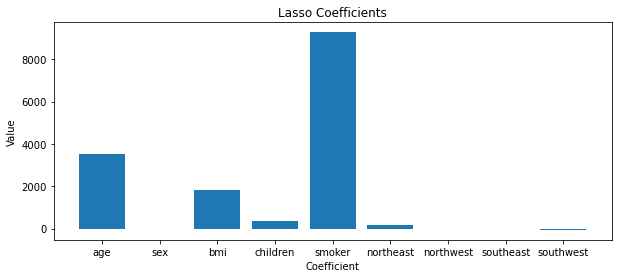

In [64]:
# Bar Graphs of Coefficients
plt.figure(figsize=(10,4))
plt.bar(
    x = var_names,
    height = coefs)
plt.title("Lasso Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Value")
plt.show()

## 7.) Interpret the coefficients

Firstly, we can quickly see that none of our features have a negative coefficient; hence, we can say that all coefficients have at least an effect that is greater than or equal to zero. Beyond this, we see the features *sex*, *northwest*, and *southeast* have 0 coefficients. This means that, based on our optimal value for $\lambda$, in order to minimize the objective function, the coefficient for these variables had to be taken to 0. Thus, they are not of importance to our model.

Beyond this, we can interpret our coefficients as measures of relative feature importance. Variables with larger coefficients are more important (since all inputs were normalized). Therefore, we see that *smoker* is the most important variable, followed up by *age* and *bmi*. *children*, *northeast* and *southwest* are also of importance, but less than the others.

## 8.) Compare in and out of sample MSE’s

In [67]:
# In and out of sample data predictions
in_pred = mod1.predict(in_data_scale)
out_pred = mod1.predict(out_data_scale)

In [78]:
# MSE using Numpy
in_MSE = np.square(np.subtract(in_target,in_pred)).mean()
out_MSE = np.square(np.subtract(out_target,out_pred)).mean()
# Alternatively could use sklearn.metrics

In [80]:
print('In Sample MSE: ', in_MSE)
print('Out Sample MSE: ', out_MSE)

In Sample MSE:  36603129.011034675
Out Sample MSE:  37305075.46630295


The in-sample MSE is about 36.6 million versus the out of sample MSE which is about 37.3 million. Hence, the out of sample MSE is larger (albeit not by too much) than the in-sample MSE. MSE, here, is extremely large; however, this is likely because of the construction of MSE:
$$\textrm{MSE} = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y}_i)^2$$
Since we are dealing with an output that is in the 1000s, the differences between our actual and predicted response could be large in absolute terms. Hence when we square them, they become massive.